In [2]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Explore Data 

In [4]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Nakhon Ratchasima')
dataset.build_all_data( build_fire=True, build_holiday = True)

th_stations ['47t']
save file ../data/nakhon_ratchasima/47t.csv
Averaging data from 2 stations
Loading all hotspots data. This might take sometimes
before drop (3888563, 18)
after drop (3764681, 10)
Getting holiday for  thailand


In [6]:
# reinit the data and load saved process data 
dataset = Dataset('Nakhon Ratchasima')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (38663, 13)


pollutants to plot Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


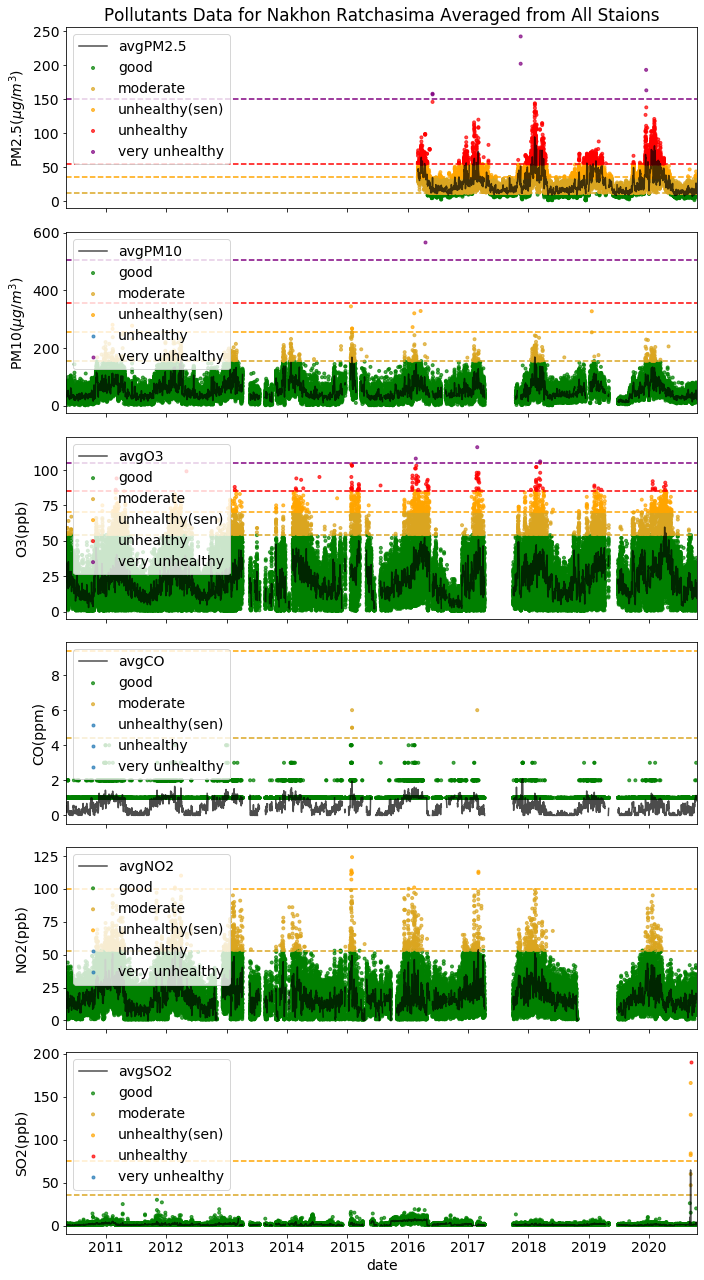

In [19]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

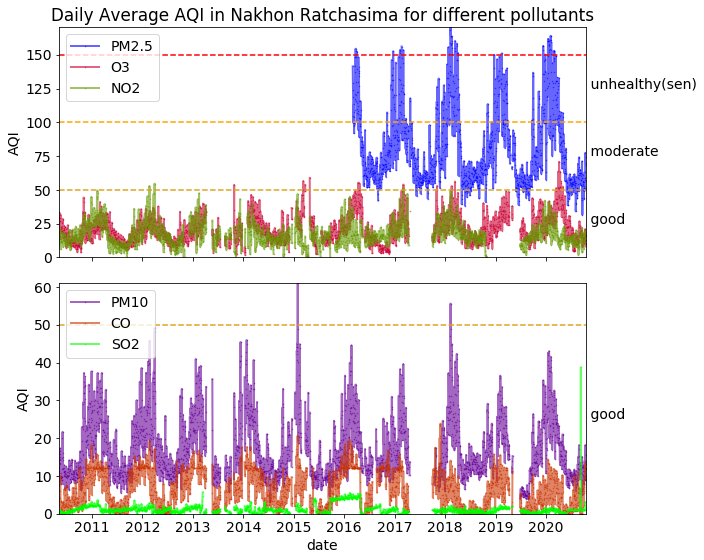

In [20]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

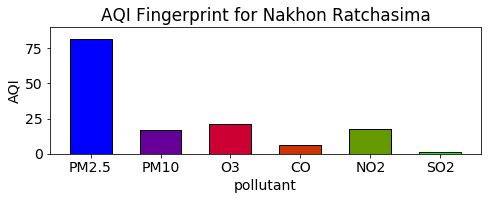

In [21]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

aqi 100 in  11-04 to 04-17
aqi 150 in  02-06 to 02-09


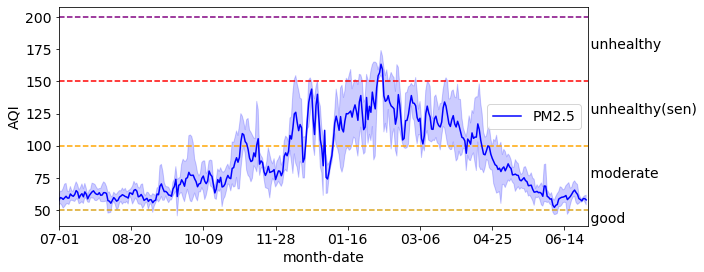

In [24]:
ax, winter_day_dict = plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

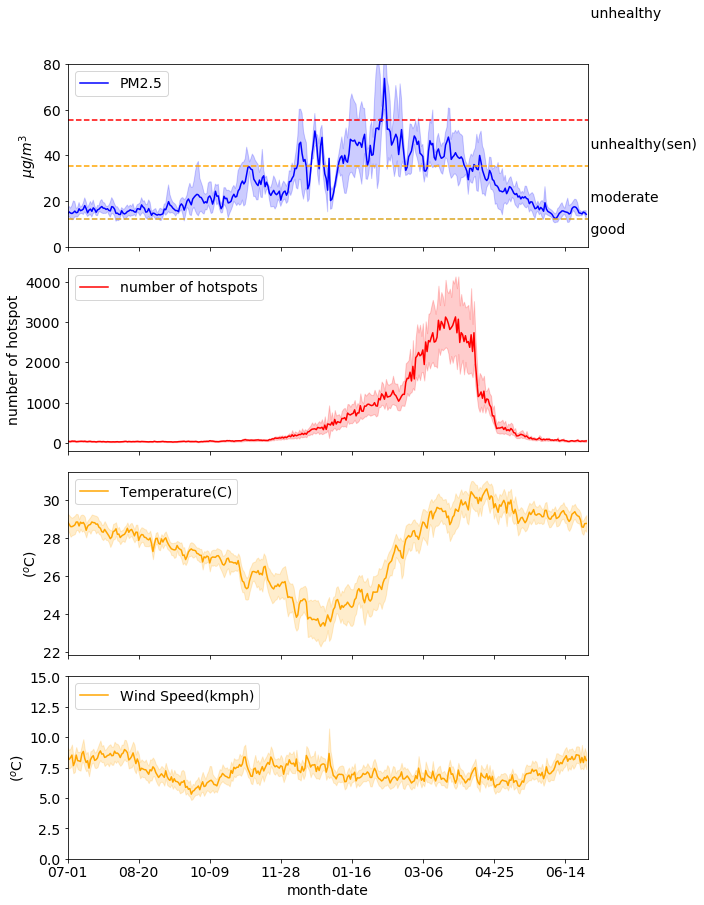

In [28]:
ax = compare_seson_avg(dataset, agg='mean')
ax[0].set_ylim([0, 80])
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

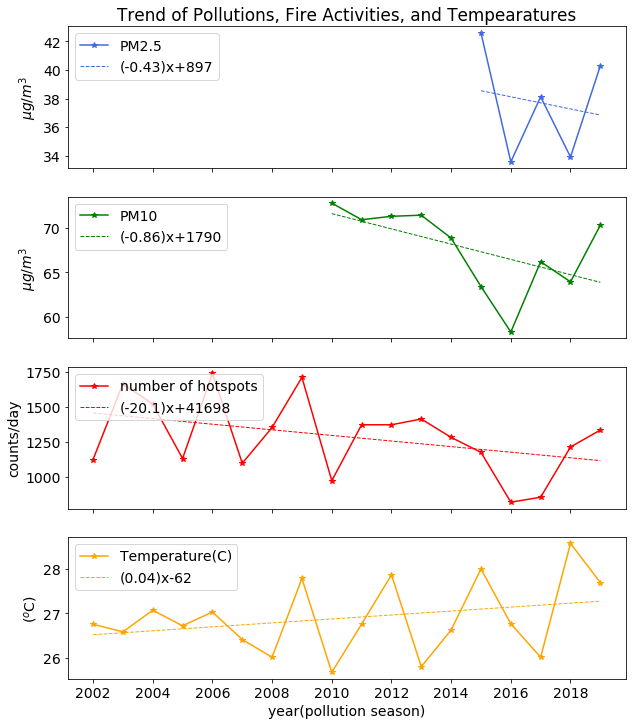

In [26]:
ax, year_avg = plot_yearly_ln(dataset, start_month='-11-01', end_month='-04-30', filename=dataset.report_folder + 'compare_ln_trends.png')

# Fire Zone

In the picture below, I divided the hotspots into 4 zones. The inner fire zone (130km) is within Thailand. The majority of the area is within Korat because it is a big province. The 130-300km zone cover most of the burning in Thailand and part of Cambodia, which is near Thailand boarder. The 300 - 600km km zone include the fire activities in Cambodia with peak burning in December, and Laos with peak burning in March. The outer most zone (600 - 1200km), blue include the burning activities in Myanmar with most burning in March. 

There are two types of crops with burning activities are: sugar cane and maize. The sugar cane crops are local to the north eastern and lower north of Thailand. The maize crops are in the north part of Thailand. These two crops have slightly different burning patterns. Although we cannot tell them apart using just the hotpots data. It different burning densities in December and March highly suggest two types of crops.  

In [17]:
# data to plot in excel
plot_data_list = []
city_x = merc_x(dataset.city_info['Longitude'])
city_y = merc_y(dataset.city_info['Latitude'])

stepx = 800E3
stepy = stepx

fire = dataset.fire

# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-0.9*stepx,city_x+1.1*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Fire Zone')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


p.circle(city_x, city_y,color='black',line_color='black',size=5, legend_label=dataset.city_info['City'])

i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
print(month)
color = 'red'
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')
plot_data_list.append(data)


month_list = ['2018-12','2019-01']
month = month_list[i]
print(month)
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')
plot_data_list.append(data)


rs = [130, 300, 600, 1200]
labels = [f'{a}_{b}km' for a, b in zip(([0] + rs), rs)]
rs.reverse()
labels.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)

for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    alpha=0.2
        
    xy = get_circle(city_x, city_y,r=r*1E3)
    plot_data_list.append(pd.DataFrame(xy.transpose(),columns=['x','y']))
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,color=color, legend_label=label)
    p.line(xy[0,:],xy[1,:],alpha=alpha,line_width=3,line_color=color)
    
show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

2019-03
2018-12


'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\nakhon_ratchasima\\fire_zone.png'

# Train Model

## PM2.5

In [ ]:
%%time
train_city_s1(city='Nakhon Ratchasima', pollutant= 'PM2.5', search_wind_damp=True, default_meta=True)

data no fire has shape (38853, 13)
=================optimize 1: find the best RF model=================
xtrn has shape (15071, 16)
{'n_estimators': 120, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.16869043898506092
val score after op_rf {'val_r2_score': 0.4231767123222151, 'val_mean_squared_error': 163.51724379163971, 'val_mean_absolute_error': 9.005520694787796}
test score after op_rf {'test_r2_score': 0.5042541314958049, 'test_mean_squared_error': 140.94685715694436, 'test_mean_absolute_error': 8.356752074761035}
=================optimize 2: remove unncessary columns=================
old cols length 16
drop is_holiday
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_130', 'fire_130_300', 'fire_300_600', 'fire_600_1200']
score after dropping columns {'r2_score': 0.43274988111170065, 'mean_squared_err